In [24]:
!pip install efficientnet

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [27]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [28]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


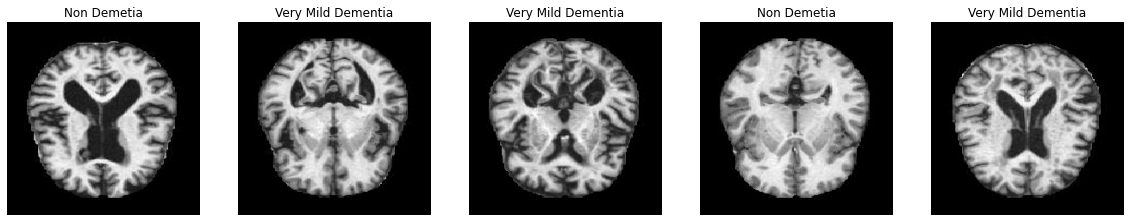

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [30]:
base_model = enet.EfficientNetB0(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

In [31]:
for layer in base_model.layers:
    layer.trainable=False

In [32]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [34]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.SGD(lr=0.01)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [35]:
filepath = './model_tuning224_128_SGD1e2.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [36]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.5196 - auc: 0.6488
Epoch 00001: val_auc improved from -inf to 0.72272, saving model to .\model_tuning224_128_SGD1e2.h5
65/65 [==============================] - 160s 2s/step - loss: 1.5196 - auc: 0.6488 - val_loss: 1.2208 - val_auc: 0.7227
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 1.2011 - auc: 0.7641
Epoch 00002: val_auc improved from 0.72272 to 0.79146, saving model to .\model_tuning224_128_SGD1e2.h5
65/65 [==============================] - 161s 2s/step - loss: 1.2011 - auc: 0.7641 - val_loss: 1.1082 - val_auc: 0.7915
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 1.0986 - auc: 0.7966
Epoch 00003: val_auc did not improve from 0.79146
65/65 [==============================] - 162s 2s/step - loss: 1.0986 - auc: 0.7966 - val_loss: 1.1270 - val_auc: 0.7652
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 1.0311 - auc: 0.8160
Epoch 00004: val_auc did no

65/65 [==============================] - ETA: 0s - loss: 0.7493 - auc: 0.8988
Epoch 00031: val_auc did not improve from 0.80049
65/65 [==============================] - 163s 3s/step - loss: 0.7493 - auc: 0.8988 - val_loss: 1.0185 - val_auc: 0.7976
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.7455 - auc: 0.9004
Epoch 00032: val_auc did not improve from 0.80049
65/65 [==============================] - 162s 2s/step - loss: 0.7455 - auc: 0.9004 - val_loss: 1.0279 - val_auc: 0.7932
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 0.7328 - auc: 0.9032
Epoch 00033: val_auc improved from 0.80049 to 0.80729, saving model to .\model_tuning224_128_SGD1e2.h5
65/65 [==============================] - 163s 3s/step - loss: 0.7328 - auc: 0.9032 - val_loss: 0.9928 - val_auc: 0.8073
Epoch 34/100
65/65 [==============================] - ETA: 0s - loss: 0.7347 - auc: 0.9042
Epoch 00034: val_auc improved from 0.80729 to 0.80767, saving model to .\model_tuning2

Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.6447 - auc: 0.9271
Epoch 00061: val_auc improved from 0.82748 to 0.83374, saving model to .\model_tuning224_128_SGD1e2.h5
65/65 [==============================] - 161s 2s/step - loss: 0.6447 - auc: 0.9271 - val_loss: 0.9409 - val_auc: 0.8337
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.6403 - auc: 0.9280
Epoch 00062: val_auc improved from 0.83374 to 0.83508, saving model to .\model_tuning224_128_SGD1e2.h5
65/65 [==============================] - 164s 3s/step - loss: 0.6403 - auc: 0.9280 - val_loss: 0.9394 - val_auc: 0.8351
Epoch 63/100
65/65 [==============================] - ETA: 0s - loss: 0.6289 - auc: 0.9304
Epoch 00063: val_auc did not improve from 0.83508
65/65 [==============================] - 164s 3s/step - loss: 0.6289 - auc: 0.9304 - val_loss: 0.9631 - val_auc: 0.8282
Epoch 64/100
65/65 [==============================] - ETA: 0s - loss: 0.6504 - auc: 0.9248
Epoch 00064: val_auc

Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.5864 - auc: 0.9389
Epoch 00091: val_auc did not improve from 0.84832
65/65 [==============================] - 160s 2s/step - loss: 0.5864 - auc: 0.9389 - val_loss: 0.9284 - val_auc: 0.8463
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.5886 - auc: 0.9388
Epoch 00092: val_auc improved from 0.84832 to 0.85166, saving model to .\model_tuning224_128_SGD1e2.h5
65/65 [==============================] - 161s 2s/step - loss: 0.5886 - auc: 0.9388 - val_loss: 0.9082 - val_auc: 0.8517
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.5926 - auc: 0.9381
Epoch 00093: val_auc did not improve from 0.85166
65/65 [==============================] - 159s 2s/step - loss: 0.5926 - auc: 0.9381 - val_loss: 0.9159 - val_auc: 0.8498
Epoch 94/100
65/65 [==============================] - ETA: 0s - loss: 0.5764 - auc: 0.9411
Epoch 00094: val_auc improved from 0.85166 to 0.85305, saving model to .\

In [37]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

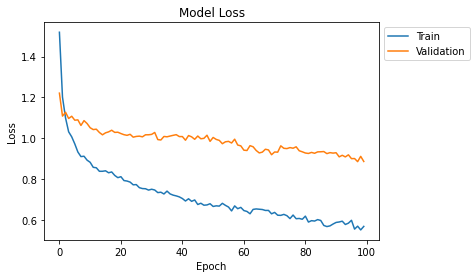

In [38]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

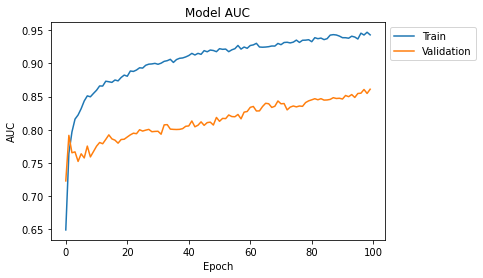

In [39]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

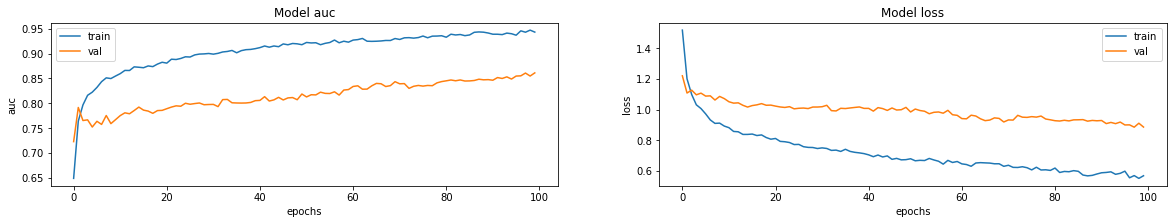

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [42]:
model.evaluate(test_dataset)

20/20 [==============================] - 37s 2s/step - loss: 0.7505 - auc: 0.9011


[0.7504730820655823, 0.9011356234550476]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
85.31 % chances are there that the image is NonDemented


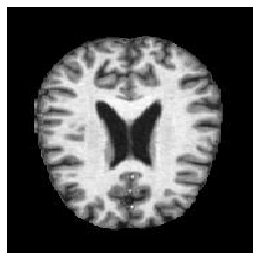

In [43]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

38.8 % chances are there that the image is MildDemented


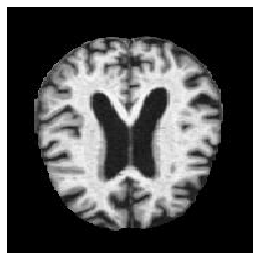

In [44]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

41.34 % chances are there that the image is VeryMildDemented


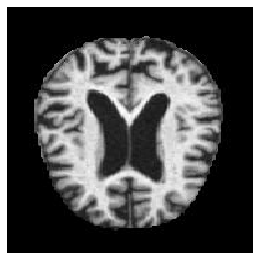

In [45]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

82.89 % chances are there that the image is VeryMildDemented


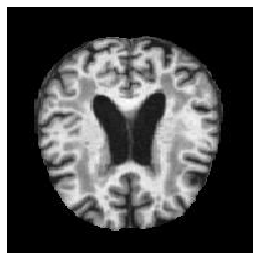

In [46]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])